In [2]:
from keras.layers import Concatenate
from keras.layers import Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
main_dir = "chest_xray/"
train_data_dir = main_dir + "train/"
validation_data_dir = main_dir + "val/"
test_data_dir = main_dir + "test/"
train_n = train_data_dir+'NORMAL/'
train_p = train_data_dir+'PNEUMONIA/'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1.0],
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

In [5]:
img_width , img_height = [224,224]
batch_size = 16
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)
 

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')
 

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'chest_xray/train/'

In [ ]:
image_batch, label_batch = next(iter(train_generator))
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
show_batch(image_batch, label_batch)

In [ ]:
input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))
#first model
base_mobilenet = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = input_shape)
base_densenet = DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_shape)
for layer in base_mobilenet.layers:
    layer.trainable =  False
for layer in base_densenet.layers:
    layer.trainable = False
model_mobilenet = base_mobilenet(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)
model_densenet = base_densenet(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)
merged = tf.keras.layers.Concatenate()([output_mobilenet, output_densenet])
x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)
stacked_model = tf.keras.models.Model(inputs = input_layer, outputs = x)

In [ ]:
tf.keras.layers.Concatenate()

In [ ]:
optm = Adam(learning_rate=0.0001)
stacked_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

In [10]:
rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

In [11]:
model_save = ModelCheckpoint('./stacked_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [12]:
nb_train_samples = 5216 # number of training samples
nb_validation_samples = 16 # number of validation samples
nb_test_samples = 624 # number of training samples
epochs = 20  # number of epochs we gonna run
batch_size  = 16 # batch size ( at every iteration it will take 16 batches fo

In [13]:
stacked_history = stacked_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                              callbacks=[EarlyStopping, model_save,rlr])

E:\Softwares\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6894 - loss: 0.6081
Epoch 1: val_loss improved from inf to 0.28430, saving model to ./stacked_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.6897 - loss: 0.6077 - val_accuracy: 0.9103 - val_loss: 0.2843 - learning_rate: 1.0000e-04
Epoch 2/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8772 - loss: 0.2851
Epoch 2: val_loss improved from 0.28430 to 0.22966, saving model to ./stacked_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.8773 - loss: 0.2851 - val_accuracy: 0.9103 - val_loss: 0.2297 - learning_rate: 1.0000e-04
Epoch 3/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9064 - loss: 0.2384
Epoch 3: val_loss improved from 0.22966 to 0.22443, saving model to ./stacked_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.9064 - loss: 0.2384 - val_accuracy: 0.9087 - val_loss: 0.2244 - learning_rate: 1.0000e-04
Epoch 4/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9200 - loss: 0.2063
Epoch 4: val_loss did not improve from 0.22443
326/326 ━━━━━━━━━━━━━━━━━━━━ 630s 2s/step - accuracy: 0.9200 - loss: 0.2062 - val_accuracy: 0.9103 - val_loss: 0.2324 - learning_rate: 1.0000e-04
Epoch 5/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9290 - loss: 0.1950
Epoch 5: val_loss did not improve from 0.22443
326/326 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.9290 - loss: 0.1949 - val_accuracy: 0.9199 - val_loss: 0.2258 - learning_rate: 1.0000e-04
Epoch 6/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9381 - loss: 0.1627
Epoch 6: val_loss improved from 0.22443 to 0.21153, saving model to ./stacked_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 591s 2s/step - accuracy: 0.9381 - loss: 0.1627 - val_accuracy: 0.9247 - val_loss: 0.2115 - learning_rate: 1.0000e-04
Epoch 7/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9325 - loss: 0.1685
Epoch 7: val_loss did not improve from 0.21153
326/326 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.9325 - loss: 0.1685 - val_accuracy: 0.9263 - val_loss: 0.2216 - learning_rate: 1.0000e-04
Epoch 8/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9361 - loss: 0.1634
Epoch 8: val_loss did not improve from 0.21153
326/326 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.9361 - loss: 0.1634 - val_accuracy: 0.9263 - val_loss: 0.2161 - learning_rate: 1.0000e-04
Epoch 9/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9325 - loss: 0.1677
Epoch 9: val_loss improved from 0.21153 to 0.19837, saving model to ./stacked_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 592s 2s/step - accuracy: 0.9325 - loss: 0.1676 - val_accuracy: 0.9279 - val_loss: 0.1984 - learning_rate: 1.0000e-04
Epoch 10/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9379 - loss: 0.1547
Epoch 10: val_loss did not improve from 0.19837
326/326 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.9378 - loss: 0.1547 - val_accuracy: 0.9183 - val_loss: 0.2065 - learning_rate: 1.0000e-04
Epoch 11/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9387 - loss: 0.1524
Epoch 11: val_loss did not improve from 0.19837
326/326 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.9388 - loss: 0.1524 - val_accuracy: 0.9135 - val_loss: 0.2131 - learning_rate: 1.0000e-04
Epoch 12/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9387 - loss: 0.1498
Epoch 12: val_loss improved from 0.19837 to 0.19336, saving model to ./stacked_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.9387 - loss: 0.1497 - val_accuracy: 0.9247 - val_loss: 0.1934 - learning_rate: 1.0000e-04
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 6.


In [14]:
def process_image(image):
    image = image/255
    image = cv2.resize(image, (224,224))
    return image

In [27]:
import cv2
import numpy as np

def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image

def testing(model, test_df):
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0][0])
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    actual_label = test_df['label']
    # print(final_base_pred)
    print("Classification Report:", classification_report(actual_label, final_base_pred))
    matrix=confusion_matrix(actual_label, final_base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

In [29]:
import pandas as pd
import os

# Define test directories
normal_dir = os.path.join(test_data_dir, "NORMAL")
pneumonia_dir = os.path.join(test_data_dir, "PNEUMONIA")

# Collect file paths and labels
test_images = []
test_labels = []

for img_file in os.listdir(normal_dir):
    test_images.append(os.path.join(normal_dir, img_file))
    test_labels.append(0)  # NORMAL is labeled as 0

for img_file in os.listdir(pneumonia_dir):
    test_images.append(os.path.join(pneumonia_dir, img_file))
    test_labels.append(1)  # PNEUMONIA is labeled as 1

# Create DataFrame
test_df = pd.DataFrame({
    'img_path': test_images,
    'label': test_labels
})


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

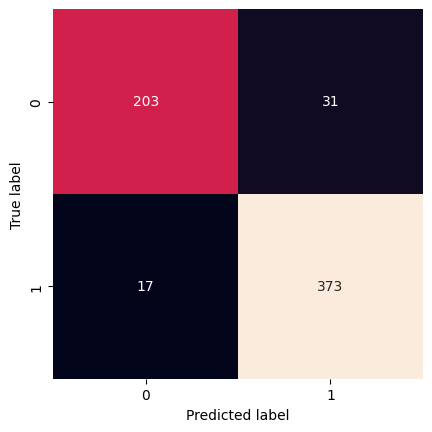

In [30]:
testing(stacked_model,test_df)

In [40]:
# Assuming you already have a trained model `stacked_model`
stacked_model.save("pneumonia_classifier.h5")

In [36]:
result, prob = PneumoniaClassifier(stacked_model).predict_pneumonia("chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")
print("Prediction:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Prediction: PNEUMONIA


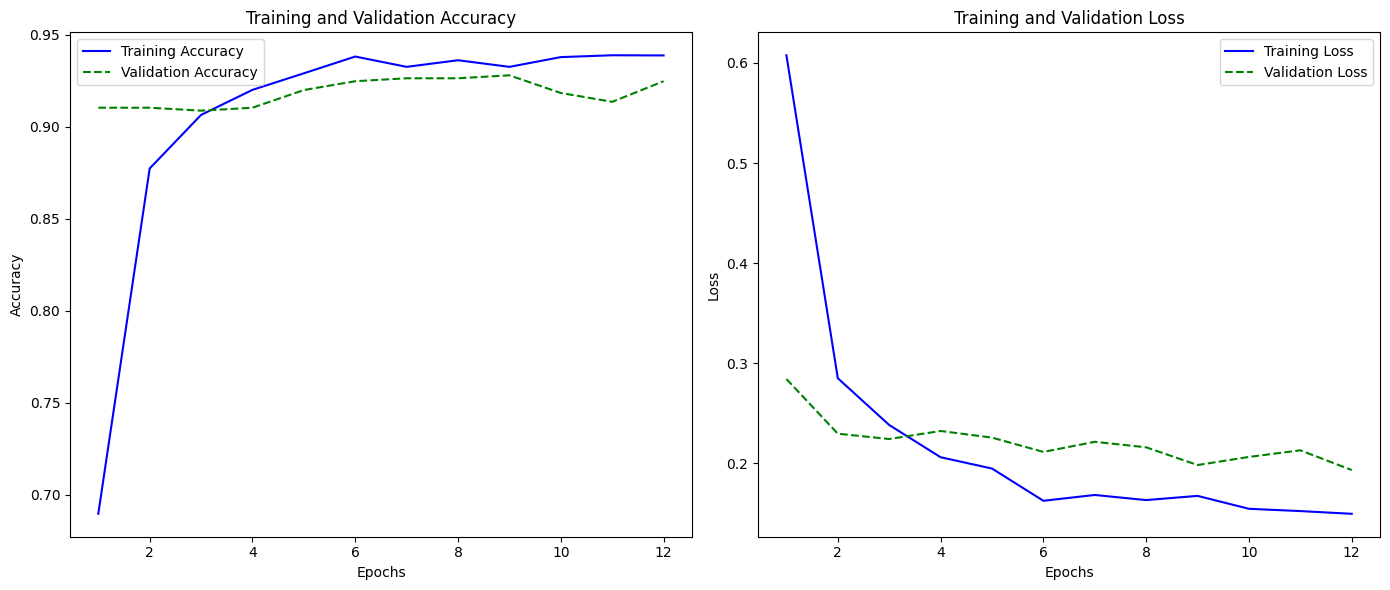

In [7]:
import matplotlib.pyplot as plt

stacked_history = {
    'accuracy': [0.6897, 0.8773, 0.9064, 0.9200, 0.9290, 0.9381, 0.9325, 0.9361, 0.9325, 0.9378, 0.9388, 0.9387],
    'val_accuracy': [0.9103, 0.9103, 0.9087, 0.9103, 0.9199, 0.9247, 0.9263, 0.9263, 0.9279, 0.9183, 0.9135, 0.9247],
    'loss': [0.6077, 0.2851, 0.2384, 0.2062, 0.1949, 0.1627, 0.1685, 0.1634, 0.1676, 0.1547, 0.1524, 0.1497],
    'val_loss': [0.2843, 0.2297, 0.2244, 0.2324, 0.2258, 0.2115, 0.2216, 0.2161, 0.1984, 0.2065, 0.2131, 0.1934],
}

def plot_training_history(history):
    epochs = range(1, len(history['accuracy']) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'g--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'g--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(stacked_history)
